In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score

In [3]:
dataset=pd.read_csv('diabetes.csv')
dataset.shape

(768, 9)

In [4]:
dataset.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [6]:
dataset.iloc[:,1:-1].describe()

,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885
std,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000
25%,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000
50%,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000
75%,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000
max,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000


In [7]:
dataset.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

## Exploratory Data Analysis

This dataset consists of one discrete and seven dependent variables. Therefore, exploratory data analysis have to be done separately.

The following countplot shows the frequencies of No of Pregnancies(without labels of each bar)

<AxesSubplot:xlabel='Pregnancies', ylabel='count'>

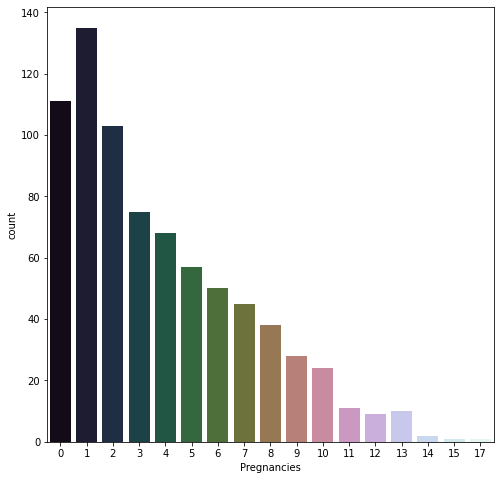

In [8]:
plt.figure(figsize=(8,8))
sns.countplot(x='Pregnancies',data=dataset,palette='cubehelix')
# There are more people with 1 pregnancy , 0 Pregnancy and 2 Pregnancies

If someone wants to know the exact counts of each no of Pregnancies, the following code will help

Text(0, 0.5, 'Counts')

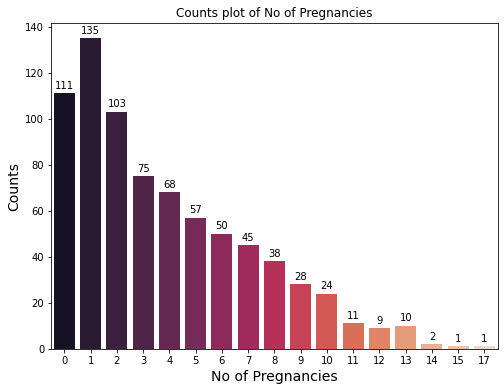

In [9]:
plt.figure(figsize=(8, 6))
counts=sns.countplot(x="Pregnancies",data=dataset,palette='rocket')
for p in counts.patches:
    counts.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 8), 
                   textcoords = 'offset points')
plt.title('Counts plot of No of Pregnancies')
plt.xlabel("No of Pregnancies", size=14)
plt.ylabel("Counts", size=14)
#plt.savefig("CountPlotPregnancies.png")

most of the people have 0,1 and 2 pregnancies

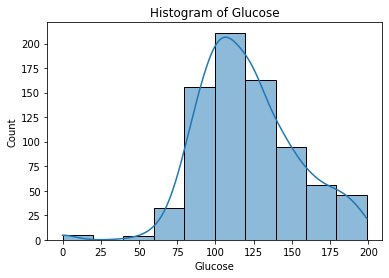

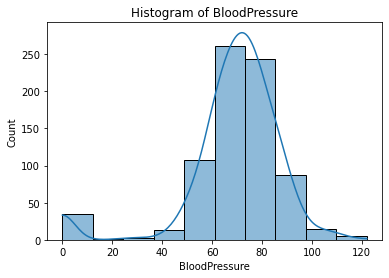

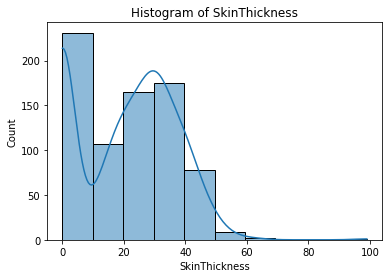

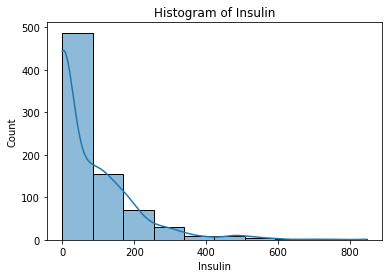

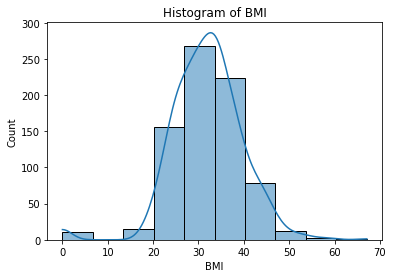

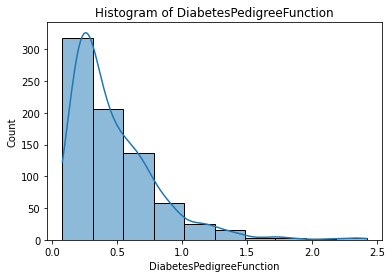

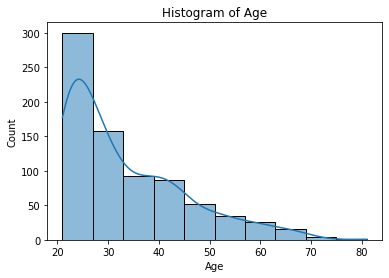

In [10]:
countinuous_feature=dataset.iloc[:,1:-1]
for feature in countinuous_feature:
    plt.figure()
    sns.histplot(data=countinuous_feature,x=feature,kde=True,bins=10)
    plt.title('Histogram of {}'.format(feature))

The above histograms and its kdes are show the distribution of each continuous variable in the dataset.
Glucose, BllodPresure and BMI are approximately normally distributed whereas Insulin, Age and DiabetesPedigreeFunction are positively skewed. In SkinThickness, there are higher number of observations in the first bin of the histogram (Most of the patients have SkinThickness between 0 and 10), because of that it can not assumed to be a normal distribution.

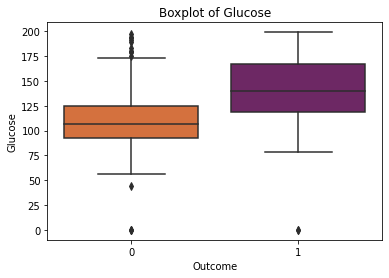

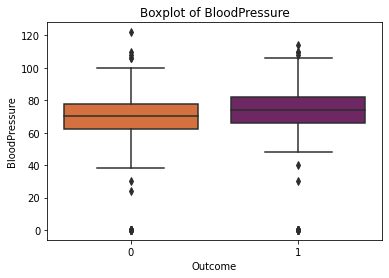

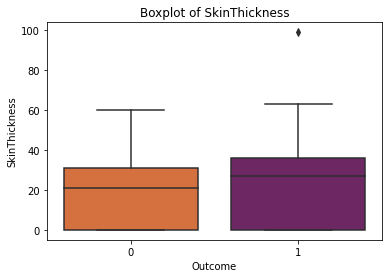

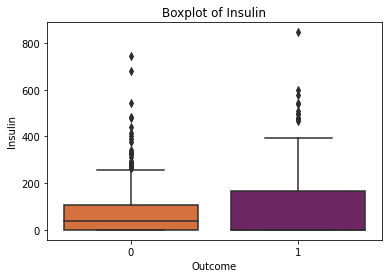

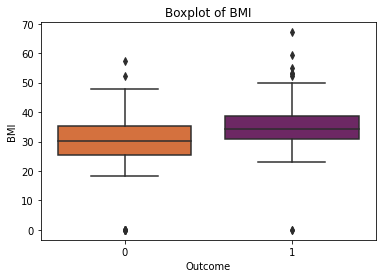

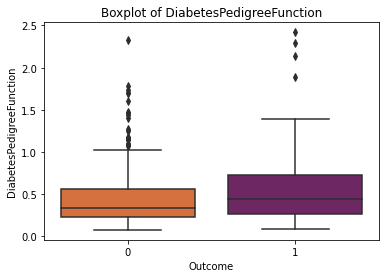

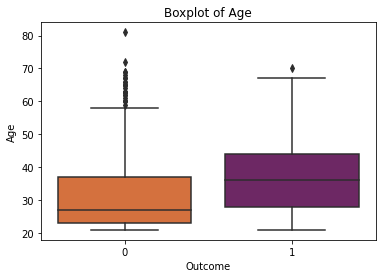

In [11]:
for feature in countinuous_feature:
    plt.figure()
    sns.boxplot(data=countinuous_feature,y=feature,x=dataset['Outcome'],palette='inferno_r')
    plt.title('Boxplot of {}'.format(feature))

The above boxplots explain, how each continuous variable is varying with each Outcome (O or 1).
All the variables are having outliers.
In BloodPresure, there is no much difference in behavior between the type of Outcome.
Eventhough Glucose follows normal distribution, there is huge difference between two types of Outcome
Similary, BMI also has much variation of behavior for two types of Outcome.
Therefore, most of the independent variables have different patterns according to the type of outcome.

In [12]:
dataset['Outcome'].value_counts() #65:35 This shows that this is balanced dataset

0    500
1    268
Name: Outcome, dtype: int64

In [13]:
for column in dataset.columns[:-1]:
    print("No of zeros in {}".format(column), "are", len(dataset[dataset[column]==0]) )

No of zeros in Pregnancies are 111
No of zeros in Glucose are 5
No of zeros in BloodPressure are 35
No of zeros in SkinThickness are 227
No of zeros in Insulin are 374
No of zeros in BMI are 11
No of zeros in DiabetesPedigreeFunction are 0
No of zeros in Age are 0


No of Pregnancies can have 0, So no need to impute any values.
All the variables are having outliers, mean is not appropriate to impute, so I prefer to use median

In [14]:
# to check the skewness of continuous variables
dataset.iloc[:,1:-1].skew(axis=0, skipna=True)

Glucose                     0.173754
BloodPressure              -1.843608
SkinThickness               0.109372
Insulin                     2.272251
BMI                        -0.428982
DiabetesPedigreeFunction    1.919911
Age                         1.129597
dtype: float64

BloodPresure,Insulin,DiabetesPedigreeFunction and Age are highly skewed before imputation

In [15]:
for column in dataset.columns[1:-3]:
    dataset[column]=dataset[column].replace(0,dataset[column].median())

In [16]:
dataset.iloc[:,1:-1].skew(axis=0, skipna=True)

Glucose                     0.535587
BloodPressure               0.141885
SkinThickness               1.223057
Insulin                     2.693181
BMI                         0.601059
DiabetesPedigreeFunction    1.919911
Age                         1.129597
dtype: float64

After median imputation, SkinThickness, Insulin, DiabetesPedigreeFunction and Age are skewed.
So, log transformation is used for these variables only.

In [17]:
log_tarnsformed=np.log(dataset[['SkinThickness','Insulin','DiabetesPedigreeFunction','Age']])

In [18]:
log_tarnsformed.head()

,SkinThickness,Insulin,DiabetesPedigreeFunction,Age
0,3.555348,3.417727,-0.466809,3.912023
1,3.367296,3.417727,-1.046969,3.433987
2,3.135494,3.417727,-0.397497,3.465736
3,3.135494,4.543295,-1.789761,3.044522
4,3.555348,5.123964,0.827678,3.496508


In [19]:
log_tarnsformed.skew()# So skewness is reduced by using log trainsformation 

SkinThickness              -0.291084
Insulin                     0.751125
DiabetesPedigreeFunction    0.114178
Age                         0.601746
dtype: float64

In [20]:
data=pd.concat([log_tarnsformed,
               dataset[['Pregnancies','Glucose','BloodPressure','BMI','Outcome']].reset_index(drop=True)],axis=1)

In [21]:
data

,SkinThickness,Insulin,DiabetesPedigreeFunction,Age,Pregnancies,Glucose,BloodPressure,BMI,Outcome
0,3.555348,3.417727,-0.466809,3.912023,6,148.0,72.0,33.6,1
1,3.367296,3.417727,-1.046969,3.433987,1,85.0,66.0,26.6,0
2,3.135494,3.417727,-0.397497,3.465736,8,183.0,64.0,23.3,1
3,3.135494,4.543295,-1.789761,3.044522,1,89.0,66.0,28.1,0
4,3.555348,5.123964,0.827678,3.496508,0,137.0,40.0,43.1,1
...,...,...,...,...,...,...,...,...,...
763,3.871201,5.192957,-1.766092,4.143135,10,101.0,76.0,32.9,0
764,3.295837,3.417727,-1.078810,3.295837,2,122.0,70.0,36.8,0
765,3.135494,4.718499,-1.406497,3.401197,5,121.0,72.0,26.2,0
766,3.135494,3.417727,-1.052683,3.850148,1,126.0,60.0,30.1,1


### model fitting

In [22]:
x=data.iloc[:,:-1]
y=data.iloc[:,8]

In [23]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3, random_state=0,stratify=y)

Decision tree has been already used and accuracy is less than random forest classifier
No need to perform scaling for tree based model, because it doesn't depending on the distance

In [24]:
RF=RandomForestClassifier()
params=[{'criterion':['gini','entropy'],
       'n_estimators':[1,5,10,20,30,40,50,100,200,300,400,500,1000],
       'max_features':['auto','sqrt'],
       'max_depth':[5,10,20,30,40,50,60,70,80,90,100],
       'min_samples_split':[2,4,6,8,10],
       'bootstrap':['True','False']}]
Diabetes_RF=RandomizedSearchCV(RF,param_distributions=params,n_iter=5,scoring='accuracy', cv=10,n_jobs=-1,random_state=0)

In [25]:
Diabetes_RF.fit(x_train,y_train)

RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(), n_iter=5,
                   n_jobs=-1,
                   param_distributions=[{'bootstrap': ['True', 'False'],
                                         'criterion': ['gini', 'entropy'],
                                         'max_depth': [5, 10, 20, 30, 40, 50,
                                                       60, 70, 80, 90, 100],
                                         'max_features': ['auto', 'sqrt'],
                                         'min_samples_split': [2, 4, 6, 8, 10],
                                         'n_estimators': [1, 5, 10, 20, 30, 40,
                                                          50, 100, 200, 300,
                                                          400, 500, 1000]}],
                   random_state=0, scoring='accuracy')

In [26]:
Diabetes_RF.best_params_

{'n_estimators': 30,
 'min_samples_split': 10,
 'max_features': 'sqrt',
 'max_depth': 40,
 'criterion': 'entropy',
 'bootstrap': 'False'}

In [27]:
y_predict=Diabetes_RF.predict(x_test)
accuracy=accuracy_score(y_predict,y_test)
accuracy

0.7835497835497836

In [28]:
#Creating a Pickle file
import pickle
pickle_out=open("Diabetes_RF.pkl","wb")
pickle.dump(Diabetes_RF,pickle_out)
pickle_out.close()

In [49]:
# To check the prediction
Diabetes_RF.predict([[6,135,140,25,34,35,2.5,51]])

array([1], dtype=int64)